#  TensorFlow Distributed Training Options 

Sometimes it makes sense to perform training on a single machine. For large datasets, however, it may be necessary to perform distributed training on a cluster of multiple machines. Cluster managment often is a pain point in the machine learning pipeline. Fortunately, Amazon SageMaker makes it easy to run distributed training without having to manage cluster setup and tear down. In this notebook, we'll examine some different options for performing distributed training with TensorFlow in Amazon SageMaker. In particular, we'll look at the following options:

- **Parameter Servers**: processes that receive asynchronous updates from worker nodes and distribute updated gradients to all workers.

- **Horovod**:  a framework based on Ring-AllReduce wherein worker nodes synchronously exchange gradient updates only with two other workers at a time.  

The model used for this notebook is a basic Convolutional Neural Network (CNN) based on [the Keras examples](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py), although we will be using the tf.keras implementation of Keras rather than the separate Keras reference implementation.  We'll train the CNN to classify images using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), a well-known computer vision dataset. It consists of 60,000 32x32 images belonging to 10 different classes, with 6,000 images per class. Here is a graphic of the classes in the dataset, as well as 10 random images from each:

![cifar10](https://maet3608.github.io/nuts-ml/_images/cifar10.png)


## Setup 

We'll begin with some necessary imports, and get an Amazon SageMaker session to help perform certain tasks, as well as an IAM role with the necessary permissions.

In [1]:
%matplotlib inline
import numpy as np
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-tf-distribution-options'
print('Bucket:\n{}'.format(bucket))

Bucket:
sagemaker-us-east-1-441707470931


Now we'll run a script that fetches the dataset and converts it to the TFRecord format, which provides several conveniences for training models in TensorFlow.

In [3]:
!python generate_cifar10_tfrecords.py --data-dir ./data

W0821 02:57:51.541942 139768691464000 deprecation_wrapper.py:119] From generate_cifar10_tfrecords.py:35: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0821 02:57:51.542186 139768691464000 deprecation_wrapper.py:119] From generate_cifar10_tfrecords.py:35: The name tf.logging.ERROR is deprecated. Please use tf.compat.v1.logging.ERROR instead.

Download from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and extract.
Successfully downloaded cifar-10-python.tar.gz 170498071 bytes.
Generating ./data/validation/validation.tfrecords
Generating ./data/eval/eval.tfrecords
Done!


For Amazon SageMaker hosted training on a cluster separate from this notebook instance, training data must be stored in Amazon S3, so we'll upload the data to S3 now.

In [8]:
!aws s3 rm s3://sagemaker-us-east-1-441707470931/data/tf-distribution-options-index/data/train/train.tfrecords

delete: s3://sagemaker-us-east-1-441707470931/data/tf-distribution-options-index/data/train/train.tfrecords


In [7]:
inputs

's3://sagemaker-us-east-1-441707470931/data/tf-distribution-options-index'

In [2]:
from sagemaker.session import s3_input
inputs = sagemaker_session.upload_data(path='data', key_prefix='data/tf-distribution-options-index')
train_data = s3_input(inputs + '/train', distribution='ShardedByS3Key')
val_data = s3_input(inputs + '/validation')
eval_data = s3_input(inputs + '/validation')

## Distributed Training with Parameter Servers

A common pattern in distributed training is to use dedicated processes to collect gradients computed by “worker” processes, then aggregate them and distribute the updated gradients back to the workers. These processes are known as parameter servers. In general, they can be run either on their own machines or co-located on the same machines as the workers. In a parameter server cluster, each parameter server communicates with all workers (“all-to-all”). The Amazon SageMaker prebuilt TensorFlow container comes with a built-in option to use parameter servers for distributed training. The container runs a parameter server thread in each training instance, so there is a 1:1 ratio of parameter servers to workers. With this built-in option, gradient updates are made asynchronously (though some other versions of parameters servers use synchronous updates). 

Once we have a training script (see `train_ps.py` in the /code directory), the next step is to set up an Amazon SageMaker TensorFlow Estimator object with the details of the training job.  It is very similar to an Estimator for training on a single machine, except we specify a `distributions` parameter to enable starting a parameter server on each training instance. 

In [5]:
from sagemaker.tensorflow import TensorFlow

ps_instance_type = 'ml.c4.2xlarge'
ps_instance_count = 4

model_dir = "/opt/ml/model"

distributions = {'parameter_server': {
                    'enabled': True}
                }
hyperparameters = {'epochs': 10, 'batch-size' : 128}

estimator_ps = TensorFlow(base_job_name='ps-cifar10-tf',
                       source_dir='code',
                       entry_point='train_ps.py', 
                       role=role,
                       framework_version='1.13',
                       py_version='py3',
                       hyperparameters=hyperparameters,
                       train_instance_count=ps_instance_count, 
                       train_instance_type=ps_instance_type,
                       model_dir=model_dir,
                       tags = [{'Key' : 'Project', 'Value' : 'cifar10'},{'Key' : 'TensorBoard', 'Value' : 'dist'}],
                       distributions=distributions)

Now we can call the `fit` method of the Estimator object to start training. After training completes, the tf.keras model will be saved in the SavedModel .pb format so it can be served by a TensorFlow Serving container. Note that the model is only saved by the the lead node (disregard any warnings about the model not being saved by all the processes).

In [ ]:
remote_inputs = {'train' : train_data, 'validation' : val_data, 'eval' : val_data}
estimator_ps.fit(remote_inputs, wait=True)

2019-08-21 07:43:37 Starting - Starting the training job...
2019-08-21 07:43:38 Starting - Launching requested ML instances.........
2019-08-21 07:45:08 Starting - Preparing the instances for training...
2019-08-21 07:46:06 Downloading - Downloading input data...
2019-08-21 07:46:33 Training - Training image download completed. Training in progress..
2019-08-21 07:46:35,925 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-08-21 07:46:35,930 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-08-21 07:46:35,942 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2019-08-21 07:46:35,942 sagemaker_tensorflow_container.training INFO     Launching parameter server process
2019-08-21 07:46:35,942 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2019-08-21 07:46:36,123 sagemaker_tensorflow_container.training INF

After training is complete, it is always a good idea to take a look at training curves to diagnose problems, if any, during training and determine the representativeness of the training and validation datasets.  We can do this with TensorBoard, and also with the Keras API: conveniently, the Keras `fit` invocation returns a data structure with the training history. In our training script, this history is saved on the lead training node, then uploaded with the model when training is complete.

To retrieve the history, we first download the model locally, then unzip it to gain access to the history data structure. We can then simply load the history as JSON:

In [13]:
import json 

!aws s3 cp {estimator_ps.model_data} ./ps_model/model.tar.gz
!tar -xzf ./ps_model/model.tar.gz -C ./ps_model

with open('./ps_model/ps_history.p', "r") as f:
    ps_history = json.load(f)

download: s3://sagemaker-us-east-1-441707470931/ps-cifar10-tf-2019-08-09-06-13-38-451/output/model.tar.gz to ps_model/model.tar.gz


Now we can plot the history with two graphs, one for accuracy and another for loss. Each graph shows the results for both the training and validation datasets. Although training is a stochastic process that can vary significantly between training jobs, overall you are likely to see that the training curves are converging smoothly and steadily to higher accuracy and lower loss, while the validation curves are more jagged. This is due to the validation dataset being relatively small and thus not as representative as the training dataset.

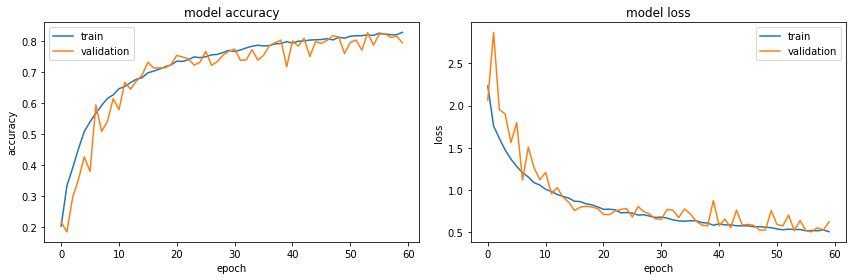

In [14]:
import matplotlib.pyplot as plt

def plot_training_curves(history): 
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    ax = axes[0]
    ax.plot(history['acc'], label='train')
    ax.plot(history['val_acc'], label='validation')
    ax.set(
        title='model accuracy',
        ylabel='accuracy',
        xlabel='epoch')
    ax.legend()

    ax = axes[1]
    ax.plot(history['loss'], label='train')
    ax.plot(history['val_loss'], label='validation')
    ax.set(
        title='model loss',
        ylabel='loss',
        xlabel='epoch')
    ax.legend()
    fig.tight_layout()
    
plot_training_curves(ps_history)

Besides saving the training history, we also can save other artifacts and data from the training job. For example, we can include a callback in the training script to save each model checkpoint after each training epoch is complete. These checkpoints will be saved to the same Amazon S3 folder as the model, in a zipped file named `output.tar.gz` as shown below:

In [8]:
artifacts_dir = estimator_ps.model_data.replace('model.tar.gz', '')
print(artifacts_dir)
!aws s3 ls --human-readable {artifacts_dir}

s3://sagemaker-us-east-1-441707470931/ps-cifar10-tf-2019-08-09-03-00-17-681/output/
2019-08-09 03:08:54    2.0 MiB model.tar.gz
2019-08-09 03:08:54  352.5 MiB output.tar.gz


## Distributed Training with Horovod

Horovod is an open source distributed training framework for TensorFlow, Keras, PyTorch, and MXNet. It is an alternative to the more "traditional" parameter servers method of performing distributed training demonstrated above.  Horovod can be more performant than parameter servers in large, GPU-based clusters where large models are trained. In Amazon SageMaker, Horovod is only available with TensorFlow version 1.12 or newer. 

Only a few lines of code are necessary to use Horovod for distributed training of a Keras model defined by the tf.keras API.  For details, see the `train_hvd.py` script included with this notebook; the changes primarily relate to:

- importing Horovod.
- initializing Horovod.
- configuring GPU options and setting a Keras/tf.session with those options.

The Estimator object for Horovod training is very similar to the parameter servers Estimator above, except we specify a `distributions` parameter describing Horovod attributes such as the number of process per host, which is set here to the number of GPUs per machine.  Beyond these few simple parameters and the few lines of code in the training script, there is nothing else you need to do to use distributed training with Horovod; Amazon SageMaker handles the heavy lifting for you and manages the underlying cluster setup.

In [ ]:
from sagemaker.tensorflow import TensorFlow

hvd_instance_type = 'ml.p3.2xlarge'
hvd_processes_per_host = 1
hvd_instance_count = 2

distributions = {'mpi': {
                    'enabled': True,
                    'processes_per_host': hvd_processes_per_host,
                    'custom_mpi_options': '-verbose --NCCL_DEBUG=INFO -x OMPI_MCA_btl_vader_single_copy_mechanism=none'
                        }
                }

hyperparameters = {'epochs': 60, 'batch-size' : 256}

estimator_hvd = TensorFlow(base_job_name='hvd-cifar10-tf',
                       source_dir='code',
                       entry_point='train_hvd.py', 
                       role=role,
                       framework_version='1.13',
                       py_version='py3',
                       hyperparameters=hyperparameters,
                       train_instance_count=hvd_instance_count, 
                       train_instance_type=hvd_instance_type,
                       tags = [{'Key' : 'Project', 'Value' : 'cifar10'},{'Key' : 'TensorBoard', 'Value' : 'dist'}],
                       distributions=distributions)

With these changes to the Estimator, we can call its `fit` method to start training. After training completes, the tf.keras model will be saved in the SavedModel .pb format so it can be served by a TensorFlow Serving container.  Note that the model is only saved by the the master, Horovod rank = 0 process (once again disregard any warnings about the model not being saved by all the processes).

In [ ]:
remote_inputs = {'train' : inputs+'/train', 'validation' : inputs+'/validation', 'eval' : inputs+'/eval'}
estimator_hvd.fit(remote_inputs, wait=True)

We can now plot training curves for the Horovod training job similar to the curves we plotted for the parameter servers training job:

In [ ]:
!aws s3 cp {estimator_hvd.model_data} ./hvd_model/model.tar.gz
!tar -xzf ./hvd_model/model.tar.gz -C ./hvd_model

with open('./hvd_model/hvd_history.p', "r") as f:
    hvd_history = json.load(f)
    
plot_training_curves(hvd_history)

Now that both training jobs are complete, we can compare the results.  The CIFAR-10 dataset is relatively small so the training jobs do not run long enough to draw detailed conclusions. However, it is likely that you can observe some differences even though training time was short, and training is a stochastic process with different results every time. The training time can be approximated for our purposes by looking at the "Billable seconds" log output at the end of each training job (at the bottom of the log output beneath the `fit` invocation code cells).

The Horovod training job tends to take a bit longer than the parameter server training job, while producing a somewhat more accurate model. The relative speed result is consistent with research showing that Horovod is more performant for larger clusters and models, while parameter servers have the edge for smaller clusters and models such as this one. Also, asynchronous model updates like those used by the parameter servers here require more epochs to converge to more accurate models, so it is not surprising if the parameter server model training completed faster for the same number of epochs as Horovord, but was less accurate. It also is likely that you can observe that the training curves for the Horovod training job are a bit smoother, reflecting the fact that synchronous gradient updates typically are less noisy than asynchronous updates.

## Model Deployment with Amazon Elastic Inference

Amazon SageMaker supports both real time inference and batch inference. In this notebook, we will focus on setting up an Amazon SageMaker hosted endpoint for real time inference with TensorFlow Serving (TFS).  Additionally, we will discuss why and how to use Amazon Elastic Inference with the hosted endpoint.

### Deploying the Model

When considering the overall cost of a machine learning workload, inference often is the largest part, up to 90% of the total.  If a GPU instance type is used for real time inference, it typically is not fully utilized because, unlike training, real time inference usually does not involve continuously sending large batches of data to the model.  Elastic Inference provides GPU acceleration suited for inference, allowing you to add just the right amount of inference acceleration to a hosted endpoint for a fraction of the cost of using a full GPU instance.

The `deploy` method of the Estimator object creates an endpoint which serves prediction requests in near real time.  To utilize Elastic Inference with the SageMaker TFS container, simply provide an `accelerator_type` parameter, which determines the type of accelerator that is attached to your endpoint. Refer to the **Inference Acceleration** section of the [instance types chart](https://aws.amazon.com/sagemaker/pricing/instance-types) for a listing of the supported types of accelerators. 

Here we'll use a general purpose CPU compute instance type along with an Elastic Inference accelerator:  together they are much cheaper than the smallest P3 GPU instance type.

In [ ]:
predictor = estimator_hvd.deploy(initial_instance_count=1,
                                  instance_type='ml.m5.xlarge',
                                  accelerator_type='ml.eia1.medium')

###  Labels and Sample Data
  
Now that we have a Predictor object wrapping a real time Amazon SageMaker hosted enpoint, we'll define the label names and look at a sample of 10 images, one from each class.

In [ ]:
from IPython.display import Image, display

labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
images = []
for entry in os.scandir('sample-img'):
    if entry.is_file() and entry.name.endswith("png"):
        images.append('sample-img/' + entry.name)

for image in images:
    display(Image(image))

### Pre/post-postprocessing Script

The TFS container in Amazon SageMaker by default uses the TFS REST API to serve prediction requests. This requires the input data to be converted to JSON format.  One way to do this is to create a Docker container to do the conversion, then create an overall Amazon SageMaker model that links the conversion container to the TFS container with the model. This is known as an Amazon SageMaker Inference Pipeline, as demonstrated in another [sample notebook](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/sagemaker_batch_transform/working_with_tfrecords).  

However, as a more convenient alternative for many use cases, the Amazon SageMaker TFS container provides a data pre/post-processing script feature that allows you to simply supply a data transformation script.  Using such a script, there is no need to build containers or directly work with Docker.  The simplest form of a script must only (1) implement an `input_handler` and `output_handler` interface, as shown in the code below, (2) be named `inference.py`, and (3) be placed in a `/code` directory.

In [ ]:
!cat ./code/inference.py

On the input preprocessing side, the code takes an image read from Amazon S3 and converts it to the required TFS REST API input format.  On the output postprocessing side, the script simply passes through the predictions in the standard TFS format without modifying them. Alternatively, we could have just returned a class label for the class with the highest score, or performed other postprocessing that would be helpful to the application consuming the predictions. 

### Requirements.txt

Besides an `inference.py` script implementing the handler interface, it also may be necessary to supply a `requirements.txt` file to ensure any necessary dependencies are installed in the container along with the script.  For this script, in addition to the Python standard libraries we used the Pillow and Numpy libraries.

In [ ]:
!cat ./code/requirements.txt

### Make Predictions

Next we'll set up the Predictor object created by the `deploy` method call above. Since we are using a preprocessing script, we need to specify the Predictor's content type as `application/x-image` and override the default (JSON) serializer. We can now get predictions about the sample data displayed above simply by providing the raw .png image bytes to the Predictor.  

In [ ]:
predictor.content_type = 'application/x-image'
predictor.serializer = None

labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

def get_prediction(file_path):
    
    with open(file_path, "rb") as image:
        f = image.read()
    b = bytearray(f)
    return labels[np.argmax(predictor.predict(b)['predictions'], axis=1)[0]]

In [ ]:
predictions = [get_prediction(image) for image in images]
print(predictions)

# Extensions

Although we did not demonstrate them in this notebook, Amazon SageMaker provides additional ways to make distributed training more efficient for very large datasets:
- **VPC training**:  performing Horovod training inside a VPC improves the network latency between nodes, leading to higher performance and stability of Horovod training jobs.

- **Pipe Mode**:  using [Pipe Mode](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html#your-algorithms-training-algo-running-container-inputdataconfig) reduces startup and training times.  Pipe Mode streams training data from S3 as a Linux FIFO directly to the algorithm, without saving to disk.  For a small dataset such as CIFAR-10, Pipe Mode does not provide any advantage, but for very large datasets where training is I/O bound rather than CPU/GPU bound, Pipe Mode can substantially reduce startup and training times.

# Cleanup

To avoid incurring charges due to a stray endpoint, delete the Amazon SageMaker endpoint if you no longer need it:

In [ ]:
sagemaker_session.delete_endpoint(predictor.endpoint)